# HW08: Word Embeddings

Remember that these homework work as a completion grade. **In this homework, we present two tasks and you can choose which one you want to solve. You only have to solve <span style="color:red">one task</span> in this homework.**
Task 1 is more guided and we evaluate document embeddings on a standard benchmark. Task 2 is very open-end and might be a starting point for your course project.

**Task 1**
In this task, we evaluate different document embeddings on the English version of the [STS Benchmark](https://arxiv.org/pdf/1708.00055.pdf). The task is to determine how semantically similar two texts are and is a popular dataset to evaluate document embeddings, i.e. we want embeddings of two semantically similar documents to be similar as well. We provide a wordcounts baseline for this task and ask you to compute and evaluate embeddings for a selected sample of document embedding techniques.

To evaluate, we follow [(Reimers and Gurevych, 2019)](https://arxiv.org/pdf/1908.10084.pdf) and compute the Spearman’s rank correlation between the cosine-similarity of the sentence embeddings and the gold labels. **It is ok to skip one of the document embedding methods**

In [1]:
from bugs import *

In [4]:
!wget -nc http://alt.qcri.org/semeval2017/task1/data/uploads/sts2017.eval.v1.1.zip
!wget -nc http://alt.qcri.org/semeval2017/task1/data/uploads/sts2017.gs.zip

#!unzip sts2017.eval.v1.1.zip 
#!unzip sts2017.gs.zip 

URL transformed to HTTPS due to an HSTS policy
File ‘sts2017.eval.v1.1.zip’ already there; not retrieving.

URL transformed to HTTPS due to an HSTS policy
File ‘sts2017.gs.zip’ already there; not retrieving.



In [20]:
import zipfile

with zipfile.ZipFile("sts2017.gs.zip") as zf:
    with zf.open("STS2017.gs/STS.gs.track5.en-en.txt") as f:
        labels = pd.read_csv(f, header=None).squeeze()

with zipfile.ZipFile("sts2017.eval.v1.1.zip") as zf:
    with zf.open("STS2017.eval.v1.1/STS.input.track5.en-en.txt") as f:
        df = pd.read_table(f, header=None, names=["a", "b"]).assign(labels=labels)

df

,a,b,labels
0,A person is on a baseball team.,A person is playing basketball on a team.,2.4
1,Our current vehicles will be in museums when e...,The car needs to some work,0.2
2,A woman supervisor is instructing the male wor...,A woman is working as a nurse.,1.0
3,A bike is next to a couple women.,A child next to a bike.,2.0
4,The group is eating while taking in a breathta...,A group of people take a look at an unusual tree.,2.2
...,...,...,...
245,A brown dog is jumping.,A brown dog is jumping,5.0
246,the man is catching a ball,A man is kicking a ball.,3.0
247,Two men are sitting in the room.,Two men are standing in a room.,3.0
248,A group of teenagers in red shirts are smiling.,A group of people are wearing orange shirts.,1.2


In [48]:
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity

### Use CountVectorizer

In [22]:
# Wordcounts baseline
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
vec.fit(df.a + " " + df.b)

CountVectorizer()

In [39]:
# Cosine similarities between text `a` and text `b`
df = df.assign(cos_sim=pd.Series(cosine_similarity(a, b).squeeze() for (a, b) in zip(vec.transform(df.a), vec.transform(df.b))))

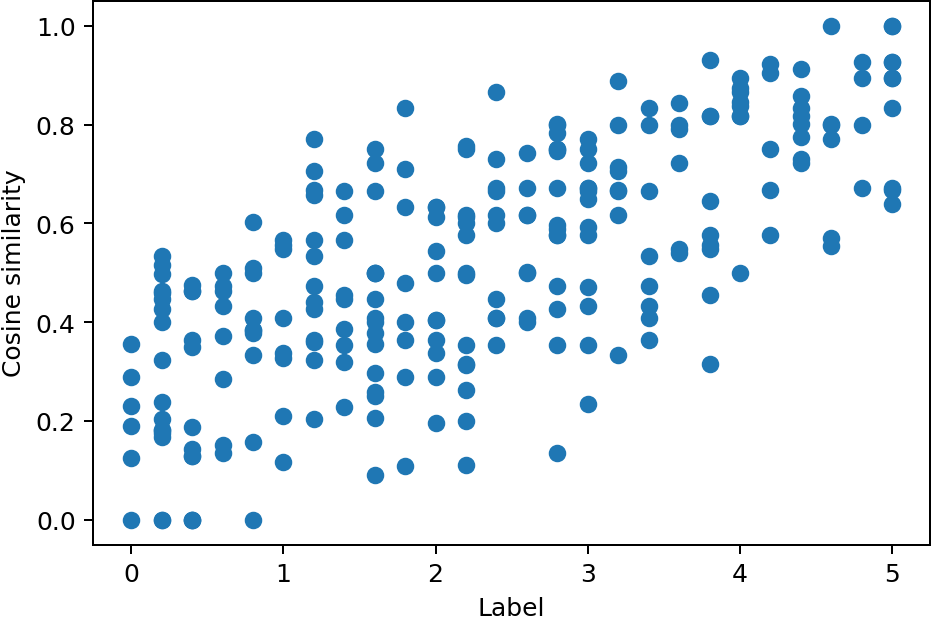

In [45]:
with Plox() as px:
    px.a.scatter(df.labels, df.cos_sim)
    px.a.set_xlabel("Label")
    px.a.set_ylabel("Cosine similarity")
    px.show()

In [47]:
spearmanr(df.labels, df.cos_sim)

SpearmanrResult(correlation=0.6998590114919738, pvalue=4.1401183445255923e-38)

### Use Doc2Vec

In [74]:
import spacy
nlp = spacy.load('en_core_web_lg')

def tokenize(text):
    return [w.lemma_.lower() for w in nlp(text) if not (w.is_stop or w.is_punct or w.is_digit)]

In [75]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

d2v = Doc2Vec(documents=[TaggedDocument(text, tags=[]) for text in (df.a + " " + df.b).apply(tokenize)], vector_size=100, window=5, min_count=10, workers=4)

aa = df.a.apply(tokenize).apply(d2v.infer_vector)
bb = df.b.apply(tokenize).apply(d2v.infer_vector)

df = df.assign(cos_sim_d2v=pd.Series(cosine_similarity([a], [b]).squeeze() for (a, b) in zip(aa, bb)))

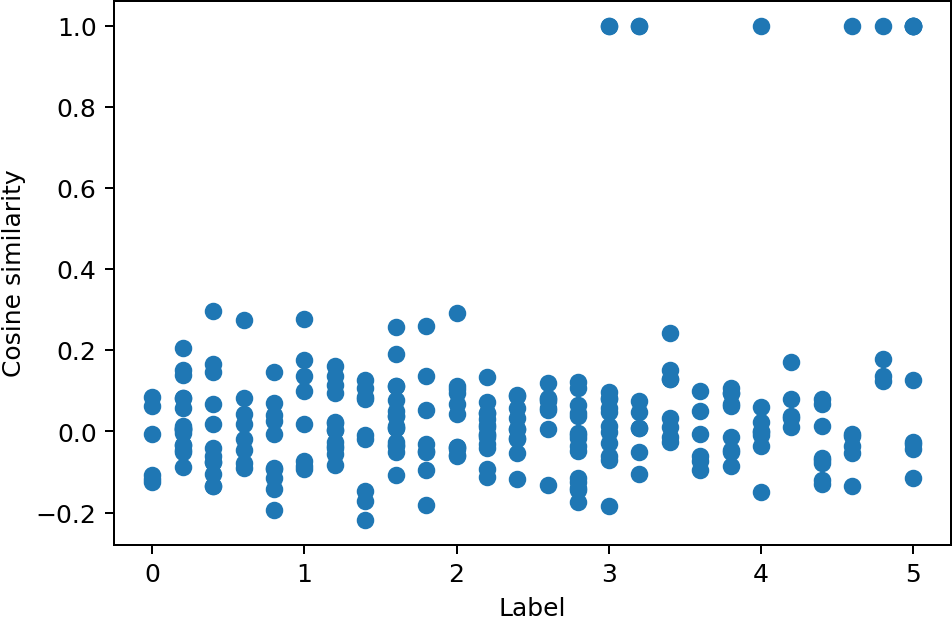

In [76]:
with Plox() as px:
    px.a.scatter(df.labels, df.cos_sim_d2v)
    px.a.set_xlabel("Label")
    px.a.set_ylabel("Cosine similarity")
    px.show()

In [77]:
spearmanr(df.labels, df.cos_sim_d2v)

SpearmanrResult(correlation=0.10917861481532005, pvalue=0.08493053418377722)

### Use spaCy embedding

In [83]:
aa = df.a.apply(nlp).apply(lambda x: x.vector)
bb = df.b.apply(nlp).apply(lambda x: x.vector)
df = df.assign(cos_sim_spacy=pd.Series(cosine_similarity([a], [b]).squeeze() for (a, b) in zip(aa, bb)))

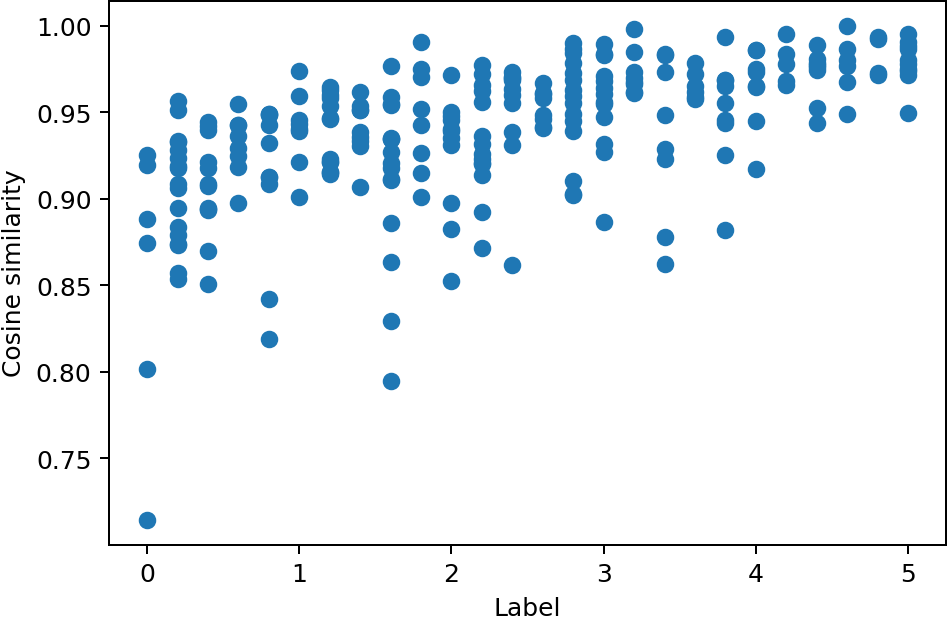

In [84]:
with Plox() as px:
    px.a.scatter(df.labels, df.cos_sim_spacy)
    px.a.set_xlabel("Label")
    px.a.set_ylabel("Cosine similarity")
    px.show()

In [115]:
spearmanr(df.labels, df.cos_sim_spacy)

SpearmanrResult(correlation=0.6492530782983145, pvalue=2.5844926331080647e-31)

### Use "universal" sentence embeddings

In [99]:
##TODO do the same with universal sentence embeddings
from transformers import pipeline, AutoTokenizer
feature_extraction = pipeline('feature-extraction', model="bert-base-uncased", tokenizer="bert-base-uncased")


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Downloading:   1%|          | 4.69M/487M [00:24<07:54, 1.02MB/s]Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertMo

In [113]:
def to_vec(text):
    return np.array(first(feature_extraction(text))).mean(axis=0)

aa = df.a.apply(to_vec)
bb = df.b.apply(to_vec)
df = df.assign(cos_sim_uni=pd.Series(cosine_similarity([a], [b]).squeeze() for (a, b) in zip(aa, bb)))

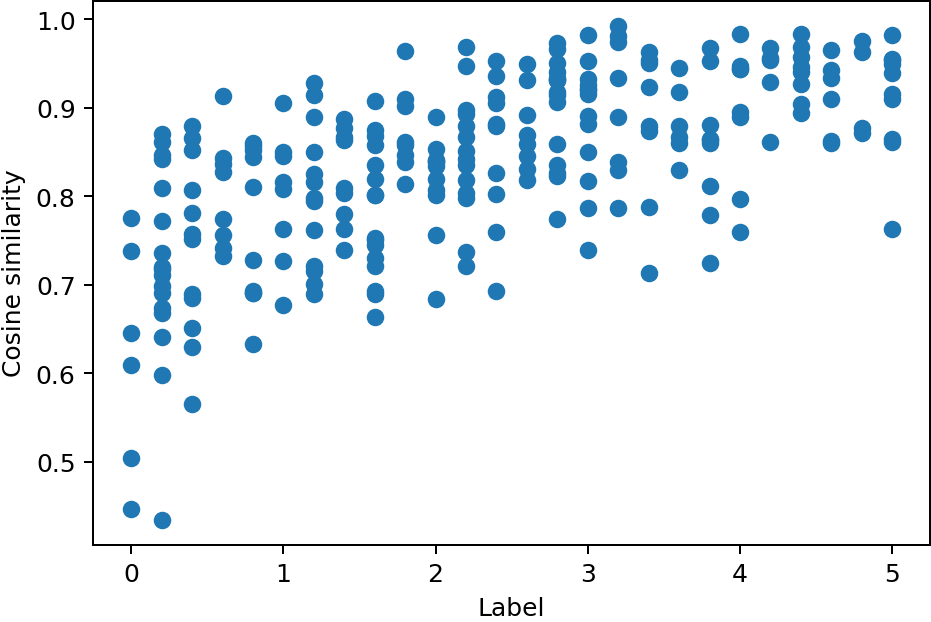

In [114]:
with Plox() as px:
    px.a.scatter(df.labels, df.cos_sim_uni)
    px.a.set_xlabel("Label")
    px.a.set_ylabel("Cosine similarity")
    px.show()

In [116]:
spearmanr(df.labels, df.cos_sim_uni)

SpearmanrResult(correlation=0.6410023907260639, pvalue=2.5110535826681473e-30)

### Use SBERT

In [97]:
from sentence_transformers import SentenceTransformer

ModuleNotFoundError: No module named 'sentence_transformers'

**Task 2**
Use your favorite document embeddings method to compute embeddings for a dataset you are interested in. Think of a method and provide some data visualization statistics (one method would be the path we have chosen in the notebook, i.e. cluster the embeddings with k-means and visualize low-dimensional representations of the document embeddings obtained by PCA). 

This task is very open and there is no right or wrong; If you want to use document embeddings in your course project, this is a chance to play around with them.

